In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scrublet as scr

In [2]:
# Refer to dataset list for IDs
DATASET_ID = "TACA24CXG08"  # TODO


In [3]:
OUTPUT_PATH = "../processed/qc3"
EXPORT_PATH = "../processed/export3"

MITO = set(open("../../../Mapping/mito.txt").read().splitlines())
RIBO = set(open("../../../Mapping/ribo.txt").read().splitlines())
with open("../../../Mapping/MappingGene.pkl", "rb") as f:
    MAPPING = pickle.load(f)


In [4]:
# Load and merge sub-datasets
datasets = []
with open("../raw/file.txt") as fi:
    for line in fi:
        fn, name = line.strip().split("\t")
        d = sc.read_h5ad("../raw/" + fn)
        datasets.append(d)
        print(name, d.shape)

adata = sc.concat(datasets, merge="unique")

print("*Merged*", adata.shape)
SHAPES = [["RAW", *adata.shape], ]


Supercluster: Non-neuronal cells (108940, 29330)
Supercluster: MGE-derived interneurons (185477, 29507)
Supercluster: Deep layer (non-IT) excitatory neurons (92969, 29348)
Supercluster: CGE-derived interneurons (129495, 29413)
Supercluster: IT-projecting excitatory neurons (638941, 30265)
*Merged* (1155822, 28189)


In [5]:
adata

AnnData object with n_obs × n_vars = 1155822 × 28189
    obs: 'Class', 'CrossArea_subclass', 'CrossArea_cluster', 'WithinArea_subclass', 'WithinArea_cluster', 'Source', 'Layer', 'Location', 'Region', 'Subregion', 'nCount_RNA', 'nFeature_RNA', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'tissue_ontology_term_id', 'is_primary_data', 'donor_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_reference', 'feature_biotype'
    obsm: 'X_UMAP'

In [6]:
if adata.raw is not None:
    print("adata has the 'raw' attribute. Replacing data with 'raw'")
    adata = adata.raw.to_adata()
else:
    print("adata does not have the raw attribute.")

print("Please confirm that adata.X currently holds the raw counts!")
print(adata.X)


adata has the 'raw' attribute. Replacing data with 'raw'
Please confirm that adata.X currently holds the raw counts!
  (0, 28183)	1.0
  (0, 28173)	1.0
  (0, 28135)	1.0
  (0, 28134)	1.0
  (0, 28123)	3.0
  (0, 28072)	1.0
  (0, 28025)	2.0
  (0, 28015)	1.0
  (0, 28006)	1.0
  (0, 27965)	1.0
  (0, 27909)	1.0
  (0, 27904)	1.0
  (0, 27897)	1.0
  (0, 27894)	2.0
  (0, 27787)	1.0
  (0, 27781)	1.0
  (0, 27753)	1.0
  (0, 27743)	1.0
  (0, 27738)	1.0
  (0, 27718)	1.0
  (0, 27713)	1.0
  (0, 27682)	1.0
  (0, 27678)	1.0
  (0, 27676)	1.0
  (0, 27667)	2.0
  :	:
  (1155821, 71)	3.0
  (1155821, 66)	1.0
  (1155821, 64)	2.0
  (1155821, 63)	1.0
  (1155821, 62)	3.0
  (1155821, 61)	2.0
  (1155821, 55)	1.0
  (1155821, 53)	1.0
  (1155821, 50)	3.0
  (1155821, 49)	4.0
  (1155821, 47)	4.0
  (1155821, 46)	1.0
  (1155821, 45)	1.0
  (1155821, 42)	4.0
  (1155821, 41)	3.0
  (1155821, 37)	2.0
  (1155821, 33)	1.0
  (1155821, 32)	2.0
  (1155821, 29)	1.0
  (1155821, 26)	1.0
  (1155821, 24)	2.0
  (1155821, 23)	9.0
  (1155821, 

In [7]:
# Dataset-level filtering if necessary, e.g., Human - Adult - Brain - 10x, etc.
# e.g., adata = adata[adata.obs["organism"] == "Homo sapiens"]
# e.g., adata = adata[adata.obs["assay"] == "10x 3' v3"]

print("No filtering")  # TODO

SHAPES.append(["DATASET_FILTERING", *adata.shape])


No filtering


In [8]:
# Replace with unique sample ID and remove all metadata. Use the same strategy from the metadata pipeline
# e.g., adata.obs["SampleID"] = adata.obs["donor_id"] 

adata.obs["SampleID"] = adata.obs["donor_id"].astype(str) + "_" + adata.obs["Region"].astype(str)  # TODO
adata.obs = adata.obs[["SampleID", "cell_type"]] # TODO if the column is not named "cell_type", change it to the one for the top level cell types
print("# of samples:", adata.obs["SampleID"].nunique())

# Rename cell IDs to DatasetID_SampleID_CellID to avoid ID collision
adata.obs_names = DATASET_ID + "_" + adata.obs["SampleID"].astype(str) + "_" + adata.obs_names


# of samples: 37


In [9]:
print(adata.var_names)

Index(['ENSG00000233576', 'ENSG00000121410', 'ENSG00000268895',
       'ENSG00000148584', 'ENSG00000175899', 'ENSG00000245105',
       'ENSG00000166535', 'ENSG00000256069', 'ENSG00000184389',
       'ENSG00000128274',
       ...
       'ENSG00000174442', 'ENSG00000122952', 'ENSG00000198205',
       'ENSG00000198455', 'ENSG00000070476', 'ENSG00000203995',
       'ENSG00000162378', 'ENSG00000159840', 'ENSG00000074755',
       'ENSG00000036549'],
      dtype='object', name='gene', length=28189)


In [10]:
# TODO change one of the below two variables to True if gene ID conversion to Ensembl is needed
is_entrez = False
is_symbol = False

if is_entrez:
    ensembl = [MAPPING["H2B"].get(MAPPING["E2H"].get(v, ""), "") for v in adata.var_names]
elif is_symbol:
    ensembl = [MAPPING["H2B"].get(MAPPING["S2H"].get(v, ""), "") for v in adata.var_names]
if is_entrez or is_symbol:
    new_id = []
    keep = []
    exist = set()
    for e in ensembl:
        if e and e not in exist:
            new_id.append(e)
            exist.add(e)
            keep.append(True)
        else:
            keep.append(False)
    adata = adata[:, keep]
    adata.var_names = new_id
    print(f"Mapped {len(exist)}/{len(keep)} genes")  # If the ratio of the mapped gene is too low, consider using "A2H" instead of "S2H"
else:
    print("No gene ID conversion is done")

SHAPES.append(["GENEID_MAPPING", *adata.shape])


No gene ID conversion is done


In [11]:
# Calculate QC metrics
adata.var["mt"] = [v in MITO for v in adata.var_names]
adata.var["rb"] = [v in RIBO for v in adata.var_names]

print("# Mito genes: ", adata.var["mt"].sum())
print("# Ribo genes: ", adata.var["rb"].sum())

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "rb"], percent_top=None, log1p=False, inplace=True)


# Mito genes:  31
# Ribo genes:  1433


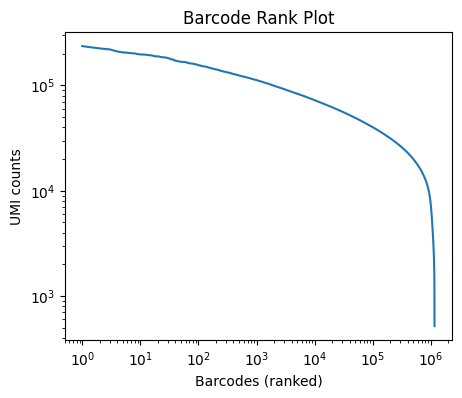

In [12]:
# Let Barcode Rank Plot tell us whether ambient RNA removal needs to be done
nUMI = pd.DataFrame(adata.obs["total_counts"])
nUMI_sorted = nUMI.sort_values(by="total_counts", ascending=False)
nUMI_sorted["rank"] = range(1, len(nUMI_sorted) + 1)
plt.figure(figsize=(5, 4))
plt.loglog(nUMI_sorted["rank"], nUMI_sorted["total_counts"])
plt.title("Barcode Rank Plot")
plt.xlabel("Barcodes (ranked)")
plt.ylabel("UMI counts")
plt.savefig(f"{OUTPUT_PATH}/QC_Barcode_Rank_Plot.svg")
plt.show()


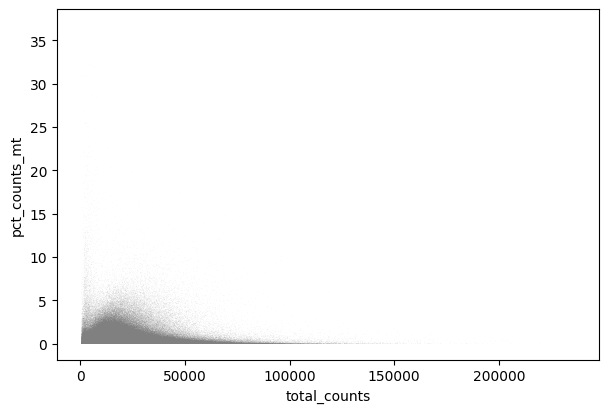

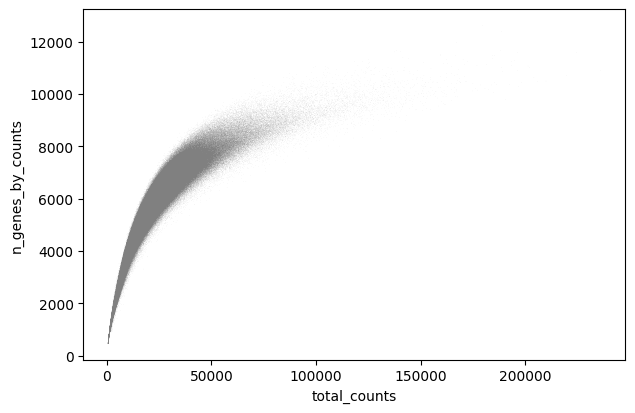

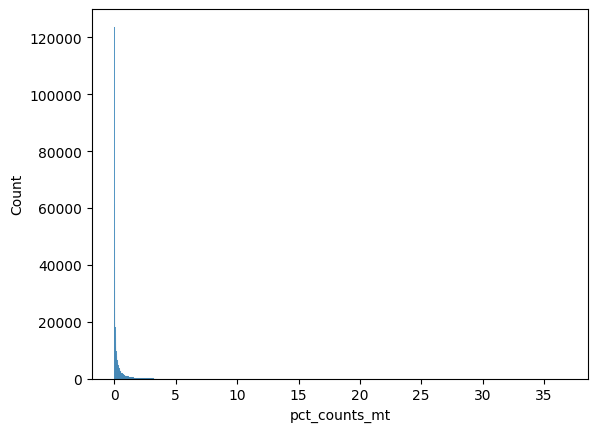

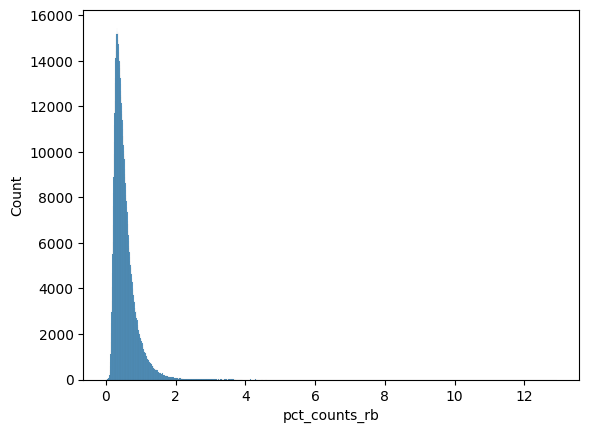

In [13]:
# Plot before QC
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", show=False)
plt.savefig(f"{OUTPUT_PATH}/QC_01.svg")
plt.show()
plt.close()

sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", show=False)
plt.savefig(f"{OUTPUT_PATH}/QC_02.svg")
plt.show()
plt.close()

sns.histplot(adata.obs["pct_counts_mt"])
plt.savefig(f"{OUTPUT_PATH}/QC_03.svg")
plt.show()
plt.close()

sns.histplot(adata.obs["pct_counts_rb"])
plt.savefig(f"{OUTPUT_PATH}/QC_04.svg")
plt.show()
plt.close()


In [14]:
# Universal QC
QCs = [
    adata.var["n_cells_by_counts"] >= 10,
    adata.obs["n_genes_by_counts"] >= 200,
    adata.obs["total_counts"] > 500,
]
QC_ROW_PASS = np.ones(adata.shape[0], dtype=bool) & QCs[1] & QCs[2]
QC_COL_PASS = np.ones(adata.shape[1], dtype=bool) & QCs[0]

SHAPES.append(["QC_1_PASS", QC_ROW_PASS.sum(), QC_COL_PASS.sum()])
SHAPES.append(["  MIN_CELLS>=10", "-", QCs[0].sum()])
SHAPES.append(["  MIN_GENES>=200", QCs[1].sum(), "-"])
SHAPES.append(["  TOTAL_COUNTS>500", QCs[2].sum(), "-"])

adata = adata[QC_ROW_PASS, :][:, QC_COL_PASS]


In [15]:
SHAPES

[['RAW', 1155822, 28189],
 ['DATASET_FILTERING', 1155822, 28189],
 ['GENEID_MAPPING', 1155822, 28189],
 ['QC_1_PASS', 1155822, 20742],
 ['  MIN_CELLS>=10', '-', 20742],
 ['  MIN_GENES>=200', 1155822, '-'],
 ['  TOTAL_COUNTS>500', 1155822, '-']]

In [16]:
# Adaptive QC
QCs = []
for field in ("total_counts", "n_genes_by_counts"):
    values = adata.obs[field]
    q75, q25 = np.percentile(values, [75, 25])
    lower_co = q25 - 3 * (q75 - q25)
    upper_co = q75 + 3 * (q75 - q25)
    QCs.append((values > lower_co) & (values < upper_co))
    print(f"Threshold for {field}: {lower_co} < x < {upper_co}")

for field, threshold in (
        ("pct_counts_mt", 10),
        ("pct_counts_rb", 20)
):
    values = adata.obs[field]
    q75, q25 = np.percentile(values, [75, 25])
    upper_co = q75 + 3 * (q75 - q25)
    QCs.append(values < max(upper_co, threshold))
    print(f"Threshold for {field}: x < {max(upper_co, threshold)}")

QC_PASS = np.ones(adata.shape[0], dtype=bool) & QCs[0] & QCs[1] & QCs[2] & QCs[3]

SHAPES.append(["QC_2_PASS", QC_PASS.sum(), "-"])
SHAPES.append(["  TOTAL_COUNTS<3IQR", QCs[0].sum(), "-"])
SHAPES.append(["  N_GENES_BY_COUNTS<3IQR", QCs[1].sum(), "-"])
SHAPES.append(["  MT_PERCENT<3IQR", QCs[2].sum(), "-"])
SHAPES.append(["  RB_PERCENT<3IQR", QCs[3].sum(), "-"])

adata = adata[QC_PASS]


Threshold for total_counts: -35639.0 < x < 73911.0
Threshold for n_genes_by_counts: -2390.0 < x < 12877.0
Threshold for pct_counts_mt: x < 10
Threshold for pct_counts_rb: x < 20


In [17]:
SHAPES

[['RAW', 1155822, 28189],
 ['DATASET_FILTERING', 1155822, 28189],
 ['GENEID_MAPPING', 1155822, 28189],
 ['QC_1_PASS', 1155822, 20742],
 ['  MIN_CELLS>=10', '-', 20742],
 ['  MIN_GENES>=200', 1155822, '-'],
 ['  TOTAL_COUNTS>500', 1155822, '-'],
 ['QC_2_PASS', 1146194, '-'],
 ['  TOTAL_COUNTS<3IQR', 1146738, '-'],
 ['  N_GENES_BY_COUNTS<3IQR', 1155822, '-'],
 ['  MT_PERCENT<3IQR', 1155277, '-'],
 ['  RB_PERCENT<3IQR', 1155822, '-']]

In [18]:
# Doublet detection
datasets = []
for sample in adata.obs["SampleID"].unique():
    sample_adata = adata[adata.obs["SampleID"] == sample].copy()
    expected = sample_adata.shape[0] / 1000 * 0.008
    print("Expected doublet rate for sample:", sample, expected)
    scrub = scr.Scrublet(sample_adata.X, expected_doublet_rate=expected)
    sample_adata.obs["doublet_scores"], sample_adata.obs["predicted_doublets"] = scrub.scrub_doublets(n_prin_comps=30)
    datasets.append(sample_adata)


Expected doublet rate for sample: H18.30.002_V1 0.5774400000000001
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 5.4%
Estimated detectable doublet fraction = 77.5%
Overall doublet rate:
	Expected   = 57.7%
	Estimated  = 7.0%
Elapsed time: 212.3 seconds
Expected doublet rate for sample: H18.30.001_V1 0.244952
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 69.4%
Overall doublet rate:
	Expected   = 24.5%
	Estimated  = 0.5%
Elapsed time: 62.5 seconds
Expected doublet rate for sample: H200.1023_V1 0.322896
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.51
Detected doub

In [ ]:
# Doublet detection
datasets = []
for sample in adata.obs["SampleID"].unique():
    sample_adata = adata[adata.obs["SampleID"] == sample].copy()
    expected = sample_adata.shape[0] / 1000 * 0.008
    print("Expected doublet rate for sample:", sample, expected)
    scrub = scr.Scrublet(sample_adata.X, expected_doublet_rate=expected)
    sample_adata.obs["doublet_scores"], sample_adata.obs["predicted_doublets"] = scrub.scrub_doublets(n_prin_comps=30)
    scrub.plot_histogram()
    plt.savefig(f"{OUTPUT_PATH}/{sample}_scrublet.svg")
    plt.close()
    # if all(pd is None for pd in sample_adata.obs["predicted_doublets"]):
    #     print('==='*15)
    #     print("Sample is {}".format(sample))
    datasets.append(sample_adata)

In [19]:
# Doublet removal
adata = sc.concat(datasets, merge="unique")
adata = adata[adata.obs["predicted_doublets"] == False]
adata.obs.drop("predicted_doublets", axis=1, inplace=True)  # To avoid a potential TypeError

SHAPES.append(["DOUBLET", adata.shape[0], "-"])


In [20]:
SHAPES

[['RAW', 1155822, 28189],
 ['DATASET_FILTERING', 1155822, 28189],
 ['GENEID_MAPPING', 1155822, 28189],
 ['QC_1_PASS', 1155822, 20742],
 ['  MIN_CELLS>=10', '-', 20742],
 ['  MIN_GENES>=200', 1155822, '-'],
 ['  TOTAL_COUNTS>500', 1155822, '-'],
 ['QC_2_PASS', 1146194, '-'],
 ['  TOTAL_COUNTS<3IQR', 1146738, '-'],
 ['  N_GENES_BY_COUNTS<3IQR', 1155822, '-'],
 ['  MT_PERCENT<3IQR', 1155277, '-'],
 ['  RB_PERCENT<3IQR', 1155822, '-'],
 ['DOUBLET', 1047059, '-']]

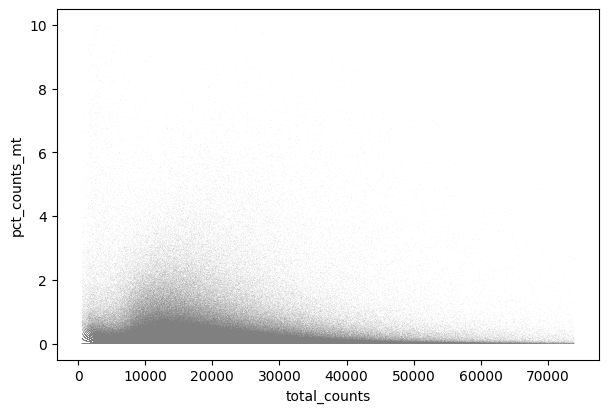

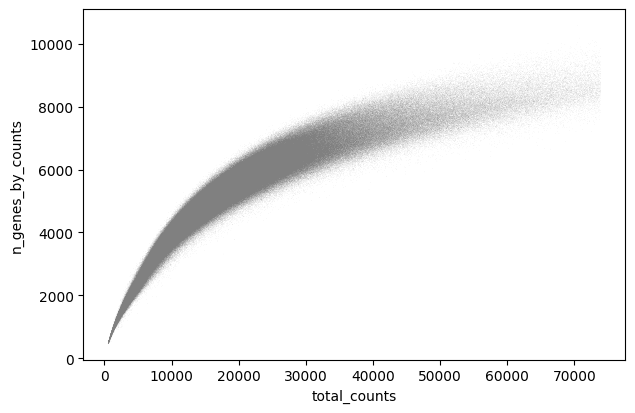

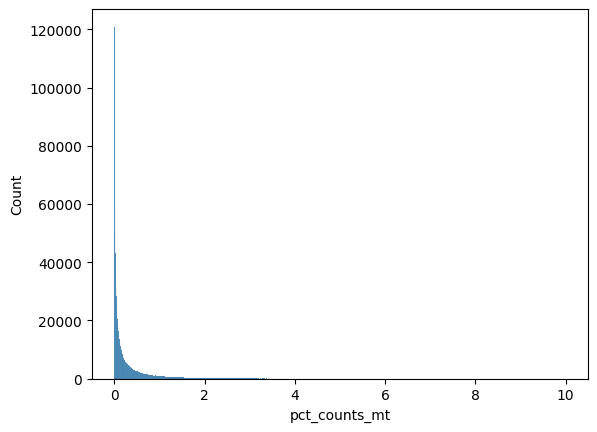

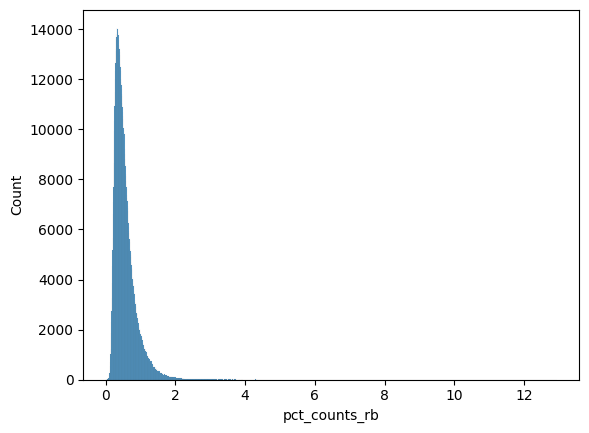

In [21]:
# Plot after QC
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", show=False)
plt.savefig(f"{OUTPUT_PATH}/QC_11.svg")
plt.show()
plt.close()

sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", show=False)
plt.savefig(f"{OUTPUT_PATH}/QC_12.svg")
plt.show()
plt.close()

sns.histplot(adata.obs["pct_counts_mt"])
plt.savefig(f"{OUTPUT_PATH}/QC_13.svg")
plt.show()
plt.close()

sns.histplot(adata.obs["pct_counts_rb"])
plt.savefig(f"{OUTPUT_PATH}/QC_14.svg")
plt.show()
plt.close()


In [22]:
# Output
SHAPES.append(["FINAL", *adata.shape])

with open(f"{OUTPUT_PATH}/QC.log", "w") as fo:
    for i, j, k in SHAPES:
        fo.write(f"{i}\t{j}\t{k}\n")

with open(f"{EXPORT_PATH}/genes.txt", "w") as fo:
    fo.write("\n".join(adata.var_names))

adata.write_h5ad(f"{EXPORT_PATH}/adata.h5ad")  # Count only

# Choose UMAP or tSNE depend on the original paper and data availability
DIM_METHOD = "UMAP"  # TODO UMAP or tSNE

X_dim = pd.DataFrame(adata.obsm["X_" + DIM_METHOD], index=adata.obs_names)
X_dim.columns = [DIM_METHOD + "_1", DIM_METHOD + "_2"]
X_dim = adata.obs[["cell_type", "SampleID"]].join(X_dim)
X_dim.to_csv(f"{EXPORT_PATH}/cell.tsv", sep="\t")

# Export normalized count for certain downstream analyses
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

from scipy import sparse, io

io.mmwrite(f"{EXPORT_PATH}/data.mtx", sparse.csr_matrix(adata.X))  # Normalized count, aka, "data"
